<a href="https://colab.research.google.com/github/Noahbisht0/Tensorflow2-keras/blob/main/Tensorflow2_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 

In [ ]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
  print(val.numpy(),end="")

0123456789

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift=1)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(),end="")
  print()

01234
12345
23456
34567
45678
56789
6789
789
89
9


In [ ]:
dataset = dataset.window(5,shift=1,drop_remainder=True)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(),end="")
  print()

01234
12345
23456
34567
45678
56789


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift=1,drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift=1,drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
dataset = dataset.map(lambda window: (window[:-1],window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
  print(x.numpy(),y.numpy())

[1 2 3 4] [5]
[3 4 5 6] [7]
[0 1 2 3] [4]
[5 6 7 8] [9]
[2 3 4 5] [6]
[4 5 6 7] [8]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift=1,drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
dataset = dataset.map(lambda window: (window[:-1],window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
  print(x.numpy(),y.numpy())

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift=1,drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
dataset = dataset.map(lambda window: (window[:-1],window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print(x.numpy(),y.numpy())

[[3 4 5 6]
 [0 1 2 3]] [[7]
 [4]]
[[1 2 3 4]
 [4 5 6 7]] [[5]
 [8]]
[[2 3 4 5]
 [5 6 7 8]] [[6]
 [9]]


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

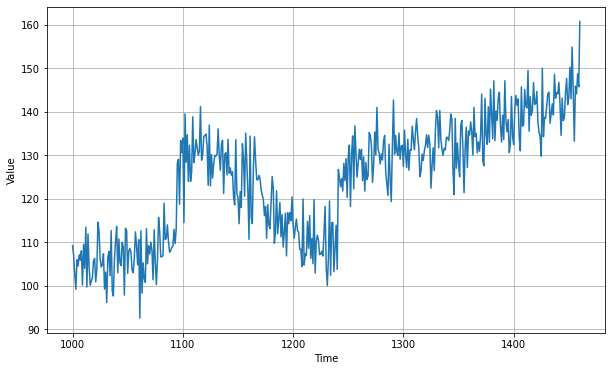

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)

In [ ]:
def window_dataset(series,window_size,batch_size,shuffle_buffer_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1,shift=1,drop_remainder=True)
  dataset = dataset.flat_map(lambda window:window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1],window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = window_dataset(x_train,window_size,batch_size,shuffle_buffer_size)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10,input_shape=[window_size],activation="relu"),
                                    tf.keras.layers.Dense(10,activation="relu"),
                                    tf.keras.layers.Dense(1)
])
model.compile(loss="mse",optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

In [ ]:
print(len(series))

1461


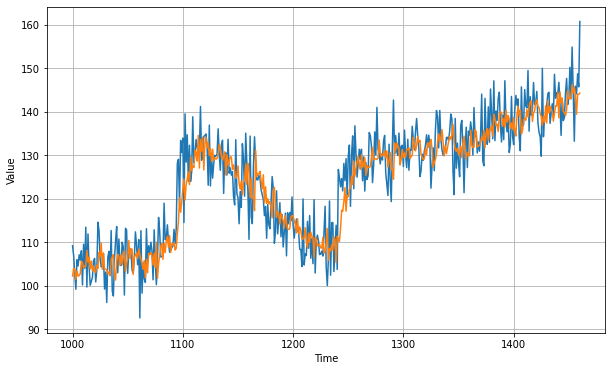

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
print(len(forecast))

461


In [ ]:
print(len(results))

461


In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid,results).numpy()

4.617588

In [ ]:
dataset = window_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/20))
optimizers = tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)
model.compile(loss="mse",optimizer=optimizers)
history = model.fit(dataset,epochs=100,callbacks=[lr_schedule],verbose=0)

(1e-08, 0.001, 0.0, 300.0)

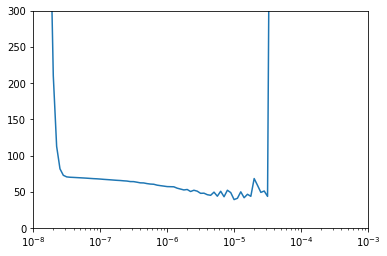

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs,history.history['loss'])
plt.axis([1e-8,1e-3,0,300])

In [ ]:
window_size = 30
dataset = window_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

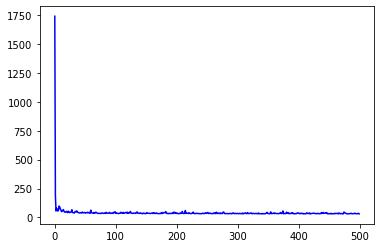

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[64.77742004394531, 49.79274368286133, 55.12844467163086, 57.79206848144531, 67.9753646850586, 55.20288848876953, 45.34807205200195, 45.338279724121094, 46.43312072753906, 51.945396423339844, 51.340980529785156, 41.168357849121094, 53.828765869140625, 46.64515686035156, 41.47544479370117, 45.094181060791016, 44.47564697265625, 47.582916259765625, 66.29289245605469, 42.941219329833984, 41.450103759765625, 38.742530822753906, 38.086795806884766, 48.93521499633789, 51.602237701416016, 46.993160247802734, 56.702491760253906, 45.8648796081543, 44.333335876464844, 40.03144836425781, 39.377662658691406, 38.66109848022461, 41.14143753051758, 39.87859344482422, 37.8629035949707, 47.01288604736328, 40.84579086303711, 39.22939682006836, 41.7110595703125, 43.573673248291016, 36.75495147705078, 41.26728820800781, 40.58150863647461, 39.73603057861328, 45.281150817871094, 40.13044357299805, 39.567317962646484, 41.903133392333984, 35.80900192260742, 62.84579086303711, 42.93896484375, 38.21815872192383

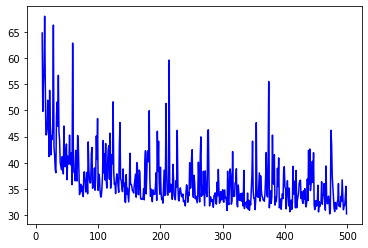

In [ ]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

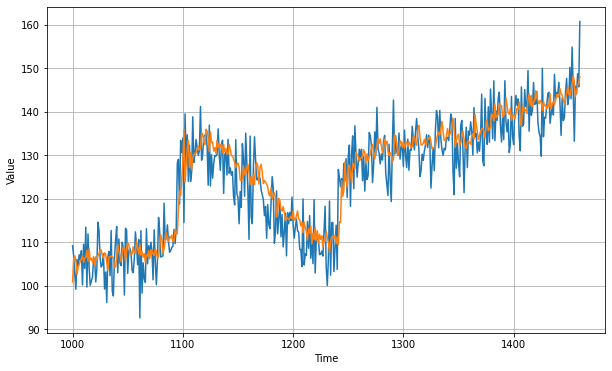

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.665792